# Описание набора данных

Данные описывают параметры постов в Telegram-канале "Корень из ИТМО". Данные были собран авторами данного проекта.

Признак  | Описание
-------------------|--------------------
headline | Текст заголовка поста
headline_words | Количество слов в тексте заголовка поста
text | Весь текст поста (включая заголовок)
text_words | Количество слов во всем тексте поста (включая заголовок)
hl_keywords | Ключевые слова заголовка поста
text_keywords | Ключевые слова всего текста поста (включая заголовок)
time | Время публикации поста в формате `HH:MM:SS`
media_amount | Количество вложений в посте
tags_amount | Количество хэштегов в посте

# Сбор данных

*Примечание: Сбор данных проводился, используя среду разработки PyCharm. В следующих двух подразделах будут указаны полные содержания файлов с кодом, используемым для парсинга.*

## Основной код, файл parse.py

Ниже представлен код для сбора данных. Код собирает данные о заданном числе постов в канале "Корень из ИТМО", начиная с новейшего. Результат записывается в файл в формате JSON для дальнейшего использования в обработке и анализе. В работе с Telegram используется библиотека Pyrogram для Python. Также для получения ключевых слов используется технология ChatGPT. В целях безопасности все API данные и телефонный номер были скрыты.

In [ ]:
import asyncio
from pyrogram import Client
import datetime
import parse_chatgpt as gpt
import json

# api_id = ########
# api_hash = '################################'
phone = '+###########'
chat_id = -1001071195907

# при первом запуске кода в переменной app создаем новую сессию my_account в telegram,
# которую будет использовать для работы код
# app = Client("my_account", api_id=api_id, api_hash=api_hash)
# после создания сессия продолжает использоваться повторно с помощью переменной app
app = Client("my_account")


# функция, которая возвращает обрезанный заголовок текста
def get_headline(content):
    if content is None:
        return content
    headline = content.split('\n\n')
    return headline[0]


# функция, которая считает и возвращает количество слов в тексте
# (в т.ч. это может быть заголовок)
def count_words(content):
    if content is None:
        return 0
    arr = content.split(' ')
    return len(arr)


# функция, возвращающая переменную времени в формате HH:MM:SS
def get_time(content):
    return content.strftime('%H:%M:%S')


# функция, подсчитывающая количество хэштегов в посте
def count_tags(content):
    count = 0
    for symbol in content:
        if symbol == "#":
            count += 1
    return count


# основная функция, отвечающая за парсинг постов
# функция ничего не возвращает, но записывает собранные данные
# в файл в формате json
async def parse():
    result = []

    # переменная для подсчета количества медиа в посте
    count = 0

    # переменная, позволяющая задать количество постов, которые необходимо обработать
    limit = 1000

    # две переменные ниже используются для отслеживания прогресса обработки постов
    loading1 = 100 / limit
    loading = loading1

    # запускаем сессию
    await app.start()

    # цикл ниже обрабатывает каждый полученный пост в диапазоне
    # от последнего (новейшего) поста до поста с номером limit.
    # так как в telegram каждое медиа считается за отдельный пост, мы проверяем,
    # что именно есть у поста, caption (текст поста с медиа) или text (текст поста без медиа),
    # и записываем полученный текст в соответствующую переменную text.
    # далее, так как caption в качестве текста поста относится только к первому медиа в посте,
    # мы не записываем данные об остальных медиа, но подсчитываем их в переменной count
    async for message in app.get_chat_history(chat_id, limit=limit):
        one_message = {}
        text = ""

        if message.text is not None:
            text = message.text

        elif message.caption is not None:
            text = message.caption
            count += 1

        else:
            count += 1

        if message.text is not None or message.caption is not None:
            # получаем ключевые слова заголовка и текста с помощью chatgpt
            hl_gpt = gpt.cgpt(get_headline(text))
            text_gpt = gpt.cgpt(text)

            # добавляем в словарь все интересующие нас данные
            one_message['headline'] = get_headline(text)
            one_message['text'] = text
            one_message['views'] = message.views
            one_message['headline_words'] = count_words(get_headline(text))
            one_message['text_words'] = count_words(text)
            one_message['hl_keywords'] = hl_gpt
            one_message['text_keywords'] = text_gpt
            one_message['time'] = get_time(message.date)
            one_message['media_amount'] = count
            one_message['tags_amount'] = count_tags(text)

            # добавляем в массив постов словарь текущего обрабатываемого поста с собранными данными
            result.append(one_message)

            count = 0
            if loading < 100:
                print(round(loading, 2), "%", sep='')

        loading += loading1

    # останавливаем сессию
    await app.stop()

    print('100%')
    print('Done')

    # записываем результат в файл в формате json
    with open('json.json', 'w', encoding='utf-8') as outfile:
        outfile.write(json.dumps(result, ensure_ascii=False, indent=2))

app.run(parse())

## Код, работающий с ChatGPT для получения ключевых слов, файл parse_chatgpt.py

Ниже представлен код для получения ключевых слов текста. Код отправляет соответствующий запрос ChatGPT, который обрабатывает его с помощью технологии GPT-3.5-Turbo и выдает ответ в запрашиваемом формате, который в последствии обрабатывается функцией и преобразовывается в список, состоящий из ключевых слов. В целях безопасности все API данные были скрыты.

In [ ]:
#!/usr/bin/python3
# -*- coding: UTF-8 -*-
import json
import os
import openai
import time
openai.api_key = "##-################################################"


# функция, отправляющая chatgpt запрос для поиска в тексте ключевых слов
# (в т.ч. это может быть как заголовок, так и полный текст поста)
def cgpt(content):
    # так как у chatgpt есть ограничение об отправке не больше трех запросов в минуту,
    # код стоит в режиме ожидание 20 секунд, перед тем как отправить новый запрос
    time.sleep(20)

    # функция, которая преобразовывает ответ, полученный от chatgpt,
    # в список, состоящий из ключевых слов
    def keywords_to_list(content):
        result = content.split(", ")
        result = result[:-1]
        return result

    # конкретный запрос для chatgpt, который отправится с текстом
    req = "\nПеречисли ключевые слова данного текста через запятую."

    # переменная req с конкретным запросом прибавляется к переменной content,
    # содержащий текст, чтобы сформировать единый запрос к chatgpt
    content += req

    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "user", "content": content}
      ]
    )

    # переменная, содержащая ответ от chatgpt
    response = completion.choices[0].message.content

    # переменная, содержащая ответ от chatgpt в формате списка,
    # полученного из ответа, преобразованного функцией keywords_to_list()
    result = keywords_to_list(response)

    return result

# Загрузка данных

Импортируем библиотеки.

In [ ]:
import pandas as pd

Скачаем данные.

In [ ]:
! gdown 1t-6fQQ3Jjfv5uZBWdZl74n99S2Uz8QbB

Downloading...
From: https://drive.google.com/uc?id=1t-6fQQ3Jjfv5uZBWdZl74n99S2Uz8QbB
To: /content/full ITMO.json
100% 1.01M/1.01M [00:00<00:00, 30.3MB/s]


Загрузим данные в датафрейм.

In [ ]:
data = pd.read_json("/content/full ITMO.json")

Еще мы загрузим маленький датасет, который является по сути частью того, что мы уже загрузили: он нам понадобится для изложения хода построения модели.

In [ ]:
! gdown 17u0cW6GbgENSLMN3K5VI3_SscrOc6Hiy

small_data = pd.read_json("/content/sqrt(ITMO).json")

Downloading...
From: https://drive.google.com/uc?id=17u0cW6GbgENSLMN3K5VI3_SscrOc6Hiy
To: /content/sqrt(ITMO).json
100% 224k/224k [00:00<00:00, 122MB/s]


Посмотрим, как выглядит наш датафрейм.

In [ ]:
data

headline  \
0    Летом прошлого года ИТМО и «Газпром нефть» под...   
1    Более половины участников опроса ВЦИОМ не смог...   
2    Если вы читаете наш канал, значит, вы точно ре...   
3                                    ИТМО + Питер = ❤️   
4    Помните всякие виртуальные приборные панели в ...   
..                                                 ...   
468  Уже два часа прошло с начала нашего 24-х часов...   
469  Мы начинаем самый долгий научный стрим ever!\n...   
470  До самого длинного научного стрима остается вс...   
471  Мы ушли на VK Fest и вернемся не раньше чем че...   
472  Уже завтра первый 24-х часовой научный стрим о...   

                                                  text  views  headline_words  \
0    Летом прошлого года ИТМО и «Газпром нефть» под...   1260              23   
1    Более половины участников опроса ВЦИОМ не смог...   1737              17   
2    Если вы читаете наш канал, значит, вы точно ре...   1602              13   
3    ИТМО + Питер = ❤️\n\nС днем рождения, город бе...   2077               5   
4    Помните всякие виртуальные приборные панели в ...   1758              21   
..                                                 ...    ...             ...   
468  Уже два часа прошло с начала нашего 24-х часов...   1628              11   
469  Мы начинаем самый долгий научный стрим ever!\n...   1626              14   
470  До самого длинного научного стрима остается вс...   1525              10   
471  Мы ушли на VK Fest и вернемся не раньше чем че...   1573              19   
472  Уже завтра первый 24-х часовой научный стрим о...   1883              21   

     text_words                                        hl_keywords  \
0            60  [ИТМО, Газпром нефть, соглашение, создание, ин...   
1            23  [опрос, ВЦИОМ, участники, достижения, мировая ...   
2            76          [наука, канал, текст, следить, регулярно]   
3            15                                      [ИТМО, Питер]   
4           111  [виртуальные приборные панели, космические кор...   
..          ...                                                ...   
468          37                      [24-х часовой, научный стрим]   
469          94                                    [научный стрим]   
470          31                           [научный стрим, длинный]   
471          43                        [VK Fest, 24 часа, обещаем]   
472         204                   [ИТМО, научный стрим, шок, улет]   

                                         text_keywords      time  \
0    [ИТМО, «Газпром нефть», инновационный индустри...  17:35:02   
1    [опрос, ВЦИОМ, достижения, мировая наука, росс...  14:11:01   
2    [наука, россияне, интерес, исследование, научн...  14:10:21   
3    [ИТМО, Питер, день рождения, город белых ночей...  12:15:35   
4    [Дополненная реальность, устройства, склады, э...  15:02:39   
..                                                 ...       ...   
468  [24-часовой, научный стрим, ученые, студия, го...  19:00:00   
469  [стрим, ученые, ответы, вопросы, горячая линия...  16:55:17   
470  [научный стрим, ученые, гости, студия, VK Fest...  16:01:57   
471  [VK Fest, 24 часа, moments, научный стрим, пло...  14:10:33   
472  [Научный стрим, ИТМО, ученые, спид-ран, горяча...  18:01:01   

     media_amount  tags_amount  
0               1            1  
1               1            0  
2               7            1  
3               1            0  
4              10            1  
..            ...          ...  
468             1            0  
469             0            0  
470             6            1  
471             5            0  
472             1            0  

[473 rows x 10 columns]

# Проверка гипотез и анализ данных

## Анализ

Для начала рассчитаем некоторые статистические данные собранного датасета.

Найдем топ-5 постов по просмотрам.

In [ ]:
data.sort_values(by="views", ascending=False).head(5)

headline  \
462  Первые в мире антисмысловые агенты для терапии...   
176                                        ATTENTION 📢   
416                                  Этот день настал.   
280  ⏱ Что можно сделать за 11 часов непрерывного к...   
79   🗣 IT повсюду: в искусстве, урбанистике, лингви...   

                                                  text  views  headline_words  \
462  Первые в мире антисмысловые агенты для терапии...  16344              12   
176  ATTENTION 📢\n\nВход со стороны Сытнинской улиц...   7684               2   
416  Этот день настал.\n\nНачинаем в 12:00. Подключ...   6629               3   
280  ⏱ Что можно сделать за 11 часов непрерывного к...   6036              21   
79   🗣 IT повсюду: в искусстве, урбанистике, лингви...   6021              13   

     text_words                                        hl_keywords  \
462          65         [ИТМО, антисмысловые агенты, терапия рака]   
176          32                                   [ключевые слова]   
416          10                                             [день]   
280         171  [11 часов, кодинг, хайповая игрушка, ИИ, студе...   
79           94  [IT, искусство, урбанистика, лингвистика, экон...   

                                         text_keywords      time  \
462  [антисмысловые агенты, терапия рака, ученые, И...  16:51:59   
176  [вход, Сытнинская улица, корпус, Кронверкский ...  18:09:02   
416                 [день, начало, 12:00, подключение]  13:49:02   
280  [кодинг, ИИ, игра, contexto.me, пользователи, ...  18:05:31   
79   [IT, кодинг, живые системы, биоинформатика, ал...  13:30:08   

     media_amount  tags_amount  
462             6            1  
176             1            1  
416             1            0  
280             1            0  
79              1            1

Вычислим среднее значение по просмотрам.

In [ ]:
mean_views = round(data.views.mean(), 2)
print('Среднее значение:', mean_views)

Среднее значение: 2498.7


Рассчитаем, какой процент подписчиков канала "Корень из ИТМО" (на момент написания отчета на канал подписано 5615 пользователей) просматривает посты в среднем, учитывая полученное раннее среднее значение просмотров.

In [ ]:
subs = 5615
value = round((mean_views * 100 / subs), 2)
print('Процент подписчиков: ', value, '%', sep='')

Процент подписчиков: 44.5%


Таким образом получаем, что меньше половины подписанных пользователей просматривают посты в канале "Корень из ИТМО".

## Гипотеза 1

**1. "Просмотры распределяются нормально."**

Для проверки данной гипотезы построим график распределения и проверим, распределяются ли данные нормально, сравнив построенный график с графиком нормального распределения, а также с распределениями Фишера, Пирсона, Чи и бета распределением.

In [ ]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25608 sha256=90df867b40696acd22a9fa6afe4f154493bcca416aed93ed5fd5b1b25daf8eb5
  Stored in directory: /root/.cache/pip/wheels/eb/50/1d/6d8762c6a9a50d3668e53f98164ba13ca314827fb5ac7ebeaa
Successfully built fitter


Импортируем fitter и matplotlib.

In [ ]:
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt

Построим графики.

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  9.83it/s]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
f            2.691294e-07  3495.621282 -10044.194437     inf      0.073461   
chi2         5.148122e-07  4963.921058  -9743.561106     inf      0.106440   
beta         5.269181e-07  4913.756786  -9726.408146     inf      0.112889   
pearson3     5.269584e-07  4911.576471  -9732.531066     inf      0.112894   
norm         1.488548e-06  8519.997806  -9247.510488     inf      0.196963   

             ks_pvalue  
f         1.150742e-02  
chi2      4.035214e-05  
beta      1.047255e-05  
pearson3  1.046127e-05  
norm      1.486963e-16

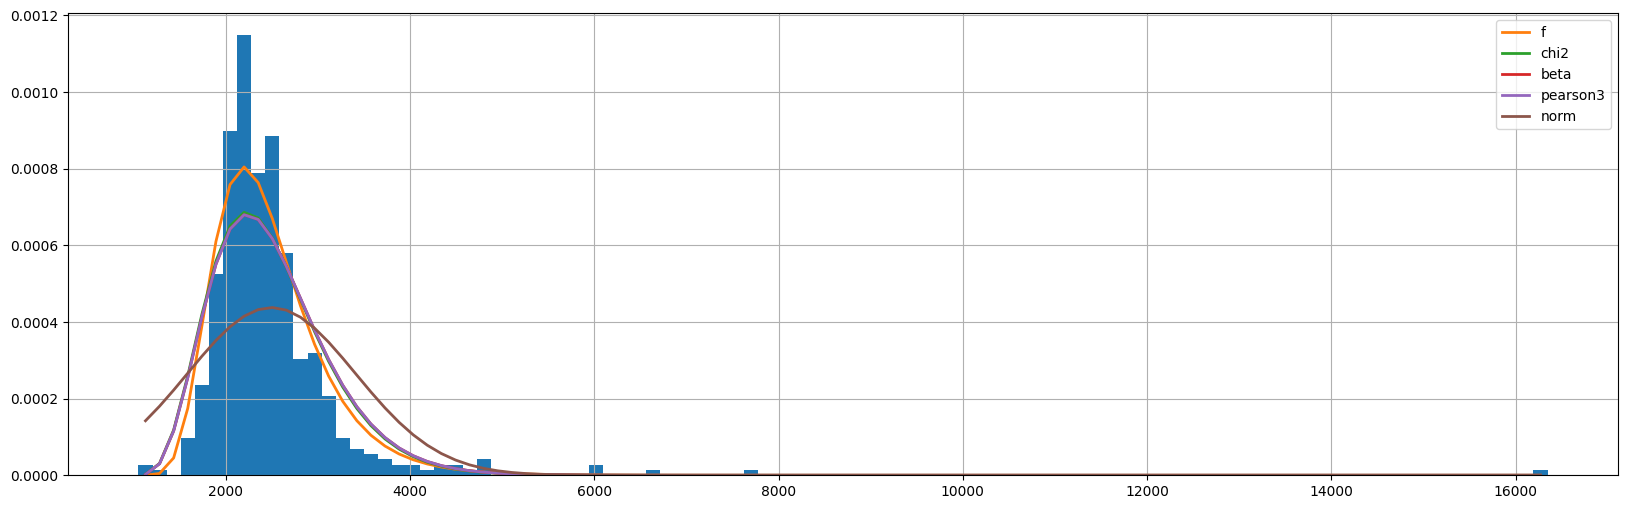

In [ ]:
plt.figure(figsize=(20,6))
f = Fitter(data.views.values, distributions=["f", "norm", "pearson3", "chi2", "beta"])
f.fit()
f.summary()

На графике видно, что нормальное распределение достаточно неплохо описывает данные, но, так как при построении графика были также построены распределения Фишера, Пирсона, Чи и бета, можно заметить, что нормальное распределение не описывет данные так хорошо, как другие распределения.

Для точного определения, какое из распределений подходит к данным о просмотрах больше всего, воспользуемся встроенной функцией get_best().

In [ ]:
f.get_best()

{'f': {'dfn': 9288.033204894231,
  'dfd': 27.077648678363197,
  'loc': 449.19145866433234,
  'scale': 1877.854746033317}}

В результате получаем, что лучше всего распределение просмотров описывает распределение Фишера, откуда следует, что гипотеза не потдвердилась, или подтвердилась частично.

## Гипотезы 2-4 (Таблица корреляции)

**2. "Между временем публикации поста и количеством просмотров есть корреляция."**

**3. "Количество просмотров зависит от длины поста — чем больше в посте слов, тем меньше просмотров."**

**4. "Чем больше в посте указано хэштегов, тем больше он получает просмотров."**

Для начала попроубем проверить гипотезы 2-4 выше, построив таблицу корреляций.

Импортируем библиотеку seaborn.

In [ ]:
import seaborn as sns

Так как время в датафрейме указано в формате "HH:MM:SS", напишем функцию для перевода времени в минуты для удобного подсчета корреляции.

In [ ]:
def hms_to_m(time):
  res = time.split(':')
  return int(res[0]) * 60 + int(res[1])

Сформируем датафрейм для подсчета корреляции.

In [ ]:
data_corr = data[["views", "text_words", "tags_amount", "media_amount", "time"]]
times = []
for i in range(len(data)):
  times.append(hms_to_m(data.time.values[i]))
data_corr["time"] = times

<ipython-input-15-c1515f9834f2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr["time"] = times


Построим таблицу корреляций.

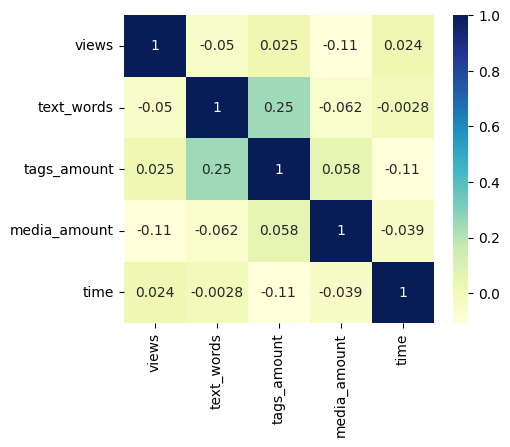

In [ ]:
cor_matrix = data_corr.corr()
fig, axis = plt.subplots(figsize=(5,4))
sns.heatmap(data=cor_matrix, annot=True, cmap="YlGnBu");

Как можно заметить, явных корреляций не наблюдается, так как значений, близких к 1 или к -1 в таблице нет. Однако можно проверить гипотезы другими способами перед тем, как сделать выводы.

## Гипотеза 2

**2. "Между временем публикации поста и количеством просмотров есть корреляция."**

Импортируем библиотеку plotly express.

In [ ]:
import plotly.express as px

Формируем датафрейм для построения гистограммы для зависимости диапазона времени от средних просмотров в этот период.

In [ ]:
data_h2 = data[["time", "views"]].sort_values(by=['time'])

In [ ]:
stat = []
for time in data_h2.time:
  if time >= '00:00:00' and time <= '02:59:59':
    stat.append('00:00 - 02:59')
  elif time >= '03:00:00' and time <= '05:59:59':
    stat.append('03:00 - 05:59')
  elif time >= '06:00:00' and time <= '08:59:59':
    stat.append('06:00 - 08:59')
  elif time >= '09:00:00' and time <= '11:59:59':
    stat.append('09:00 - 11:59')
  elif time >= '12:00:00' and time <= '14:59:59':
    stat.append('12:00 - 14:59')
  elif time >= '15:00:00' and time <= '17:59:59':
    stat.append('15:00 - 17:59')
  elif time >= '18:00:00' and time <= '20:59:59':
    stat.append('18:00 - 20:59')
  elif time >= '21:00:00' and time <= '23:59:59':
    stat.append('21:00 - 23:59')
  else:
    stat.append('')
data_h2["status"] = stat
data_h2.head(3)

time  views         status
10   00:12:30   2313  00:00 - 02:59
211  00:25:27   2462  00:00 - 02:59
445  01:01:39   1126  00:00 - 02:59

Построим график.

In [ ]:
fig = px.histogram(data_h2, x="status", y="views", histfunc="avg")
fig.show()

Как видно на гистограмме, больше всего просмотров набирают посты, опубликованные в период времени с 12 дня до 12 ночи, во второй половине дня. До 12 дня же количество просмотров в среднем меньше, чем после 12:00. Таким образом, можно сказать, что корреляция между временем публикации поста и количеством просмотров присутствует.

## Гипотеза 3

**3. "Количество просмотров зависит от длины поста —
 чем больше в посте слов, тем меньше просмотров."**

Для проверки гипотезы построим график с линией тренда. Для этого сначала подготовим датафрейм.

In [ ]:
data_h3 = data[["text_words", "views"]].sort_values(by="text_words")
data_h3.head(3)

text_words  views
407           2   3863
425           6   2524
190           7   2051

Построим график.

In [ ]:
fig = px.scatter(data_h3, y="views", x="text_words", trendline="ols")
fig.show()

Как можно заметить, в значениях просмотров есть резкие всплески. Чтобы лучше рассмотреть линию тренда, ограничим количество просмотров диапазоном от 0 до 6 тыс, а количество слов диапазоном от 0 до 250.

In [ ]:
data_h3 = data_h3[((data_h3.views <= 6000) & (data_h3.text_words <= 250))]
data_h3.head(3)

text_words  views
407           2   3863
425           6   2524
190           7   2051

Снова построим график.

In [ ]:
fig = px.scatter(data_h3, y="views", x="text_words", trendline="ols")
fig.show()

Как видно по линии тренда, количество просмотров практически не меняется с увеличением количества слов, что означает, что гипотеза не верна.

## Гипотеза 4

**4. "Чем больше в посте указано хэштегов, тем больше он получает просмотров."**

Подготовим датафрейм, содержащий данные о количестве хэштегов в постах и просмотрах.

In [ ]:
data_h4 = data[["tags_amount", "views"]]

Построим блочную диаграмму для полученного датафрейма.

In [ ]:
fig = px.box(data_h4, x="tags_amount", y="views", color="tags_amount")
fig.show();

Опять же, наблюдается резкий всплеск в количестве просмотров на единичных постах, в связи с чем стоит ограничить диапазон просмотров от 0 до 6 тыс.

In [ ]:
data_h4 = data_h4[(data_h4.views <= 6000)]

Снова построим блочную диаграмму.

In [ ]:
fig = px.box(data_h4, x="tags_amount", y="views", color="tags_amount")
fig.show();

На блочной диаграмме явно видно, что в принципе наличие хэштегов в среднем увеличивает количество просмотров на посте. Однако, на постах, где 2 хэштега в среднем меньше просмотров, чем на постах с 1 хэштегом. Поэтому можно утверждать, что гипотеза не подтвердилась.

## Гипотеза 5

**5. Наиболее частовстречающееся ключевое слово в посте это "ИТМО".**

Соединим все собранные ключевые слова в один лист.

In [ ]:
keywords = data["text_keywords"]
result = []
for klist in keywords:
  result += klist
result[:3]

['ИТМО', '«Газпром нефть»', 'инновационный индустриальный центр']

Сформируем новый датафрейм, где будут храниться все собранные ключевые слова. К каждому слову в отдельном столбце назначим значение count = 1, которое будет использоваться для дальнейшего подсчета.

In [ ]:
data_h5 = pd.DataFrame({"keyword": result, "count": [1] * len(result)})
data_h5.head(3)

keyword  count
0                                ИТМО      1
1                     «Газпром нефть»      1
2  инновационный индустриальный центр      1

Посчитаем количество упоминаний ключевого слова в датафрейме и отберем топ-20 ключевых слов.

In [ ]:
data_h5 = data_h5.groupby("keyword").sum().reset_index().sort_values(by="count").tail(20)
data_h5.head(3)

keyword  count
2104                программа     11
1262  искусственный интеллект     13
1632                    митап     13

Построим круговую диаграмму.

In [ ]:
fig = px.sunburst(data_h5, path=['keyword'], values='count')
fig.show()

Слово "ИТМО" упоминается среди ключевых слов намного более часто, что свидетельствует о том, что гипотеза подтвердилась.

## Гипотеза 6

**6. С течением времени количество просмотров увеличивается (т.е. на старых постах просмотров меньше, чем на новых)**

Сформируем датафрейм, содержащий информацию о просмотрах. Так как нумерация постов идет с новейшего, необходимо также "перевернуть" датафрейм.

In [ ]:
data_h6 = data[["views"]].iloc[::-1].reset_index()[["views"]]
data_h6.head(3)

views
0   1883
1   1573
2   1525

Построим график на основе полученных данных.

In [ ]:
fig = px.scatter(data_h6, x=data_h6.index, y="views", trendline="ols")
fig.show()

Снова наблюдаем всплески в просмотрах, поэтому ограничим их 6 тысячами.

In [ ]:
data_h6 = data_h6[(data_h6.views <= 6000)]
data_h6.head(3)

views
0   1883
1   1573
2   1525

Снова построим график.

In [ ]:
fig = px.scatter(data_h6, x=data_h6.index, y="views", trendline="ols")
fig.show()

На графике видно, что количество просмотров на постах почти не меняется с течением времени от старейших до новейших постов. Гипотеза не потвердилась.

# Получение эмбеддингов

Получим эмбеддинги для текстовых полей нашего датафрейма.

Установим библиотеку `transformers`.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 117.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.9 MB/s eta 0:00:00


Теперь импортируем нужные нам библиотеки и проверим, что доступна GPU для быстрого выполнения вычислительных операций.

In [ ]:
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from typing import List, Dict
from tqdm import tqdm
from transformers import (
    AutoModel, AutoTokenizer
)

import pickle

USE_CUDA = torch.cuda.is_available()
USE_CUDA

False

Создадим список используемых языковых моделей (для русского языка).

In [ ]:
models = ['sberbank-ai/ruRoberta-large',
          'sberbank-ai/sbert_large_nlu_ru',
          'sberbank-ai/sbert_large_mt_nlu_ru',
          'sberbank-ai/ruBert-large',
          'sberbank-ai/ruBert-base',
          'cointegrated/rubert-tiny2',
          'DeepPavlov/rubert-base-cased-conversational'
]

Напишем функцию для подсчета оптимальной длины токена предложения.

In [ ]:
def count_token_lengths(sentences: List[str], model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    lengths = []
    for sentence in sentences:
        encoded_input = tokenizer(
                [sentence],
                padding='max_length',
                truncation=True,
                return_tensors='pt'
        )
        lengths.append(len(encoded_input['input_ids'][0]))
    return lengths

Создадим списки с такими длинами для каждой из моделей.

In [ ]:
text_token_lengths = dict()
headline_token_lengths = dict()
for model in models:
    text_token_lengths[model] = (count_token_lengths(data["text"].values, model))
    headline_token_lengths[model] = (count_token_lengths(data["headline"].values, model))

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Визуализируем полученные значения для каждой из моделей.

Text: sberbank-ai/ruRoberta-large


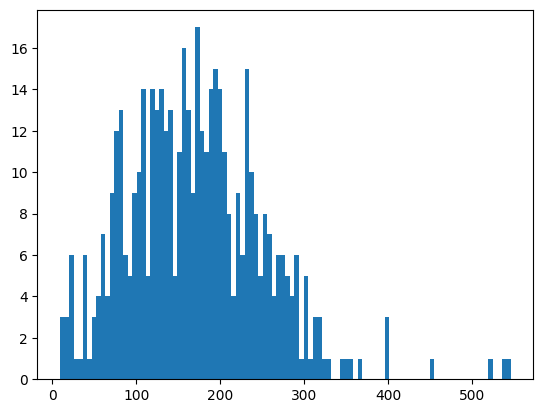

Headline: sberbank-ai/ruRoberta-large


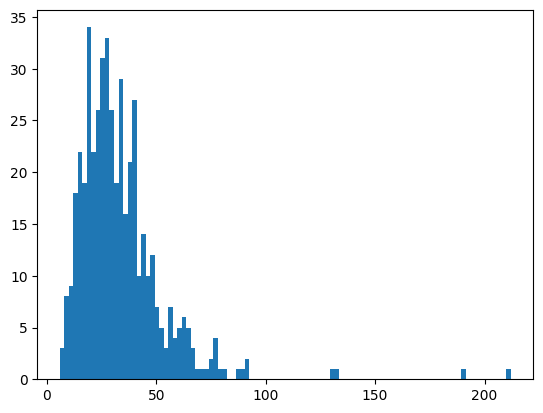

Text: sberbank-ai/sbert_large_nlu_ru


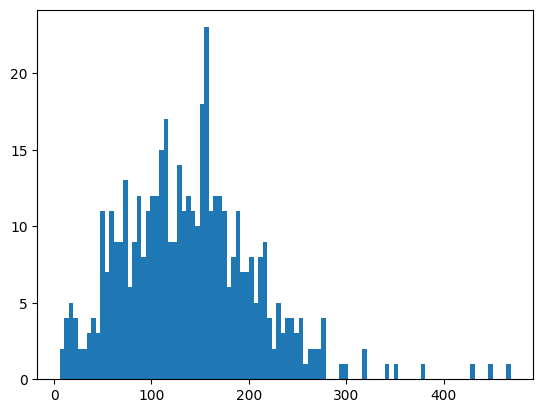

Headline: sberbank-ai/sbert_large_nlu_ru


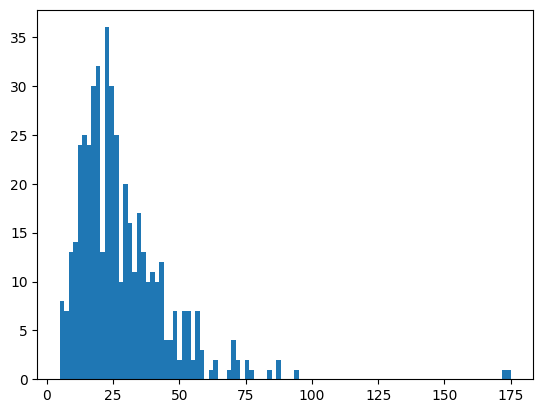

Text: sberbank-ai/sbert_large_mt_nlu_ru


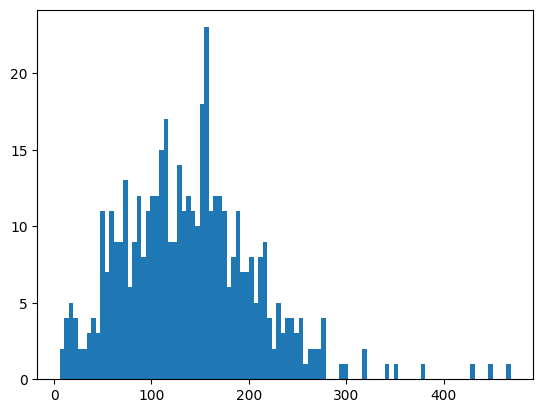

Headline: sberbank-ai/sbert_large_mt_nlu_ru


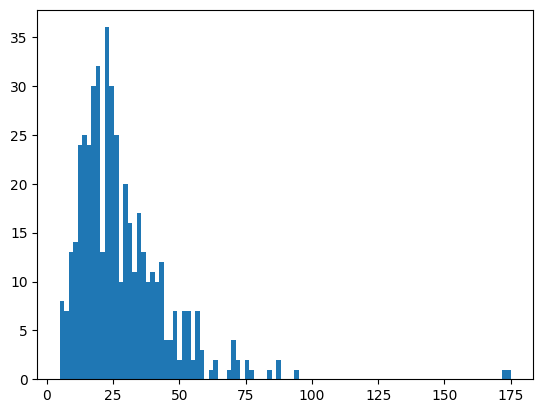

Text: sberbank-ai/ruBert-large


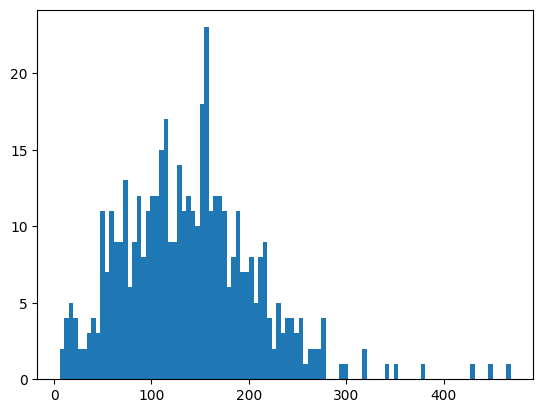

Headline: sberbank-ai/ruBert-large


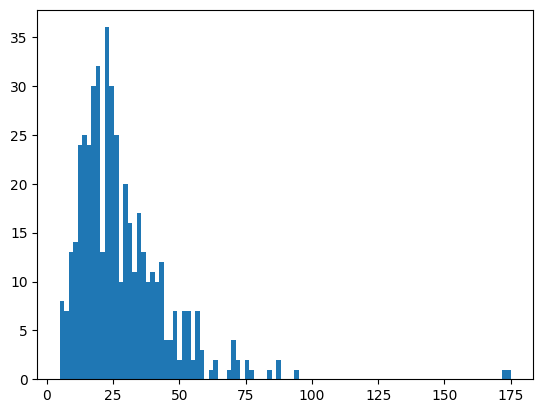

Text: sberbank-ai/ruBert-base


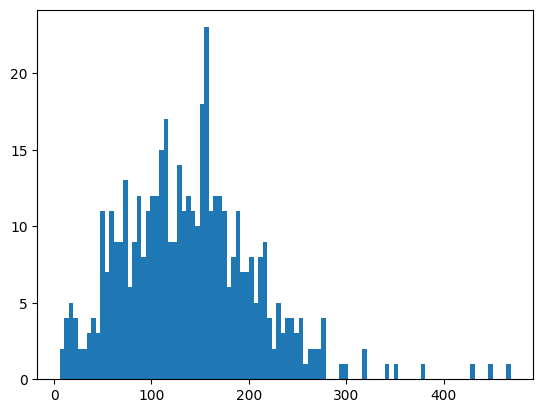

Headline: sberbank-ai/ruBert-base


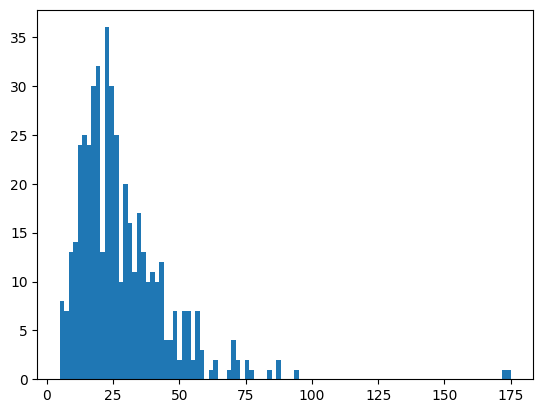

Text: cointegrated/rubert-tiny2


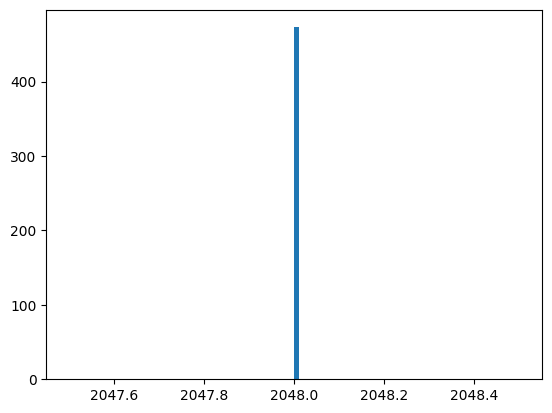

Headline: cointegrated/rubert-tiny2


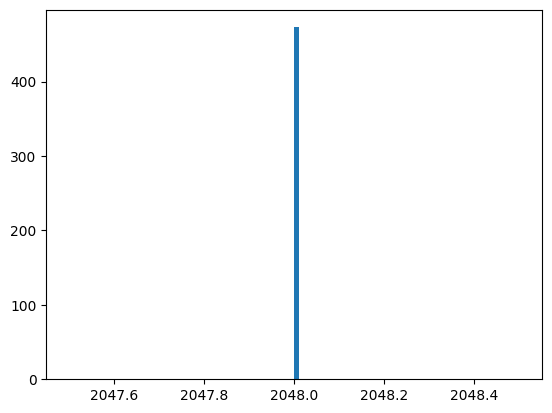

Text: DeepPavlov/rubert-base-cased-conversational


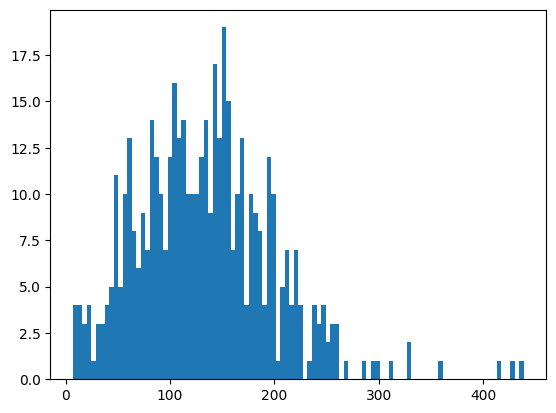

Headline: DeepPavlov/rubert-base-cased-conversational


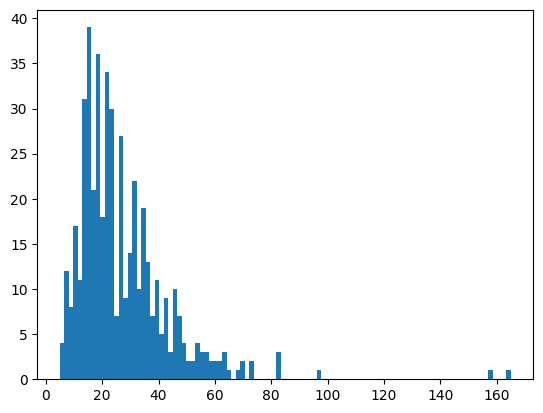

In [ ]:
for model in models:
    print("Text:", model)
    plt.hist(text_token_lengths[model], bins=100)
    plt.show()

    print("Headline:", model)
    plt.hist(headline_token_lengths[model], bins=100)
    plt.show()

Возьмем такую длину токена предложения, чтобы в 95% случаев токен предложения соответствовал самому предложению целиком (небольшое незначительное количество данных тем самым отбрасывается).

In [ ]:
text_max_lengths = {model: np.quantile(text_token_lengths[model], 0.95) for model in models}
headline_max_lengths = {model: np.quantile(headline_token_lengths[model], 0.95) for model in models}

Напишем функцию для усреднения эмбеддингов токенов в тексте

In [ ]:
def mean_pooling(model_output, attention_mask):
    # Первый элемент model_output содержит эмбеддинги всех токенов текста
    token_embeddings = model_output[0].detach().cpu()
    # Маска для токенайзера для унификации длины предложения
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    # Получение только присутствующих в предложениях эмбеддингов и суммирование
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    # Замена нулей на очень малые значения для корректного выполнения дальнейших операций
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Возвращаем усредненное значение эмбеддингов с учетом количества токенов
    return sum_embeddings / sum_mask

Также напишем функцию, которая при использовании трансформера получает усредненный эмбеддинг текста. На входе список предложений sentences, название обученной языковой модели, максимальное количество токенов в предложении, по умолчанию CUDA не используется.

In [ ]:
def make_features_transformers(
    sentences: List[str],
    max_lengths: Dict[str, float],
    model_name: str,
    use_cuda: bool = False,
):
    # Разбиение на токены
    tokenizer = AutoTokenizer.from_pretrained(
        model_name
    )
    # Загрузка обученной модели
    model = AutoModel.from_pretrained(
        model_name
    )
    # Для выполнения вычислений на графическом процессоре
    if use_cuda:
        model = model.cuda()
    # Будущее возвращаемое значение - список усредненных эмбеддингов текста
    text_features = []

    for sentence in tqdm(
        sentences,
        total=len(sentences)
    ):
        # Токенизируем текст, получаем список id токенов и attention mask
        encoded_input = tokenizer(
            [sentence],
            padding='max_length',
            truncation=True,
            max_length=int(max_lengths[model_name]),
            return_tensors='pt'
        )
        # Получение эмбеддингов
        with torch.no_grad():
            input_ids = encoded_input['input_ids']
            if use_cuda:
                input_ids = input_ids.cuda()
            model_output = model(input_ids=input_ids)
            sentence_embeddings = list(
                mean_pooling(model_output, encoded_input['attention_mask']).numpy()
            )
            text_features.append(sentence_embeddings)
    return text_features

Скачаем эти модели и создадим словари, в которых каждому названию модели соответствует набор полученных эмбеддингов для соответствующего поля исходного датафрейма.

In [ ]:
embeddings_headline = dict()
embeddings_text = dict()

In [ ]:
for model_name in models:
    embeddings_headline[model_name] = make_features_transformers(
        data["headline"].values,
        headline_max_lengths,
        model_name,

        USE_CUDA
    )
    embeddings_text[model_name] = make_features_transformers(
        data["text"].values,
        text_max_lengths,
        model_name,
        USE_CUDA
    )

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

100%|██████████| 473/473 [00:27<00:00, 17.07it/s]


100%|██████████| 473/473 [00:29<00:00, 16.10it/s]


Some weights of the model checkpoint at sberbank-ai/ruBert-large were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 473/473 [00:12<00:00, 37.25it/s]
Some weights of the model checkpoint at sberbank-ai/ruBert-large w

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 473/473 [00:07<00:00, 63.73it/s]
Some weights of the model checkpoint at sberbank-ai/ruBert-base wer

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 473/473 [00:15<00:00, 29.66it/s]
Some weights of the model checkpoint at cointegrated/rubert-tiny2

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 473/473 [00:12<00:00, 37.98it/s]
Some weights of the model checkpoint at DeepPav

Сохраним полученные результаты в файлы.

In [ ]:
with open('embeddings_headlines.pickle', 'wb') as file_h:
    pickle.dump(embeddings_headline, file_h, protocol=pickle.HIGHEST_PROTOCOL)
with open('embeddings_texts.pickle', 'wb') as file_t:
    pickle.dump(embeddings_text, file_t, protocol=pickle.HIGHEST_PROTOCOL)

# Изучение полученных эмбеддингов для текстов и заголовков

Скачаем эти файлы снова, чтобы не создавать словари с эмбеддингами заново в случае перезапуска среды выполнения.

In [ ]:
! gdown 1UIUvrFclVO03qHkbj-soUrxOUzRL4GdQ
! gdown 1XZdS5uera9bwT1GtPw655rslGqG12XQ2

Downloading...
From: https://drive.google.com/uc?id=1UIUvrFclVO03qHkbj-soUrxOUzRL4GdQ
To: /content/embeddings_headlines.pickle
100% 11.3M/11.3M [00:00<00:00, 74.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XZdS5uera9bwT1GtPw655rslGqG12XQ2
To: /content/embeddings_texts.pickle
100% 11.3M/11.3M [00:00<00:00, 81.6MB/s]


In [ ]:
import pickle

with open('/content/embeddings_headlines.pickle', 'rb') as file_h:
    headline_embeddings= pickle.load(file_h)
with open('/content/embeddings_texts.pickle', 'rb') as file_t:
    text_embeddings = pickle.load(file_t)

In [ ]:
for number, key in enumerate(text_embeddings.keys()):
    currentTextFrame = pd.DataFrame(np.array(text_embeddings[key]).reshape(473, -1))
    currentTextFrame.columns = [key + str(i) for i in range(currentTextFrame.shape[1])]

    currentHeadlineFrame = pd.DataFrame(np.array(headline_embeddings[key]).reshape(473, -1))
    currentHeadlineFrame.columns = [key + str(i) for i in range(currentHeadlineFrame.shape[1])]
    if number != 0:
        text_features = pd.concat([text_features, currentTextFrame], axis=1)
        headline_features = pd.concat([headline_features, currentHeadlineFrame], axis=1)
    else:
        text_features = currentTextFrame
        headline_features = currentHeadlineFrame

Установим нужные библиотеки.

In [ ]:
! pip install transformers bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем нужные библиотеки.

In [ ]:
import numpy as np
import pandas as pd
import transformers
import seaborn as sns

from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TextClassificationPipeline)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import WordPunctTokenizer
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

Напишем функцию для визуализации полученных данных.

In [ ]:
def draw_vectors(x, y, radius=2, alpha=0.25, color='blue',
                 width=1000, height=500, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, 'size': radius, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', color='color', size='size', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
fig = pl.figure(active_scroll='wheel_zoom')

Нормируем данные.

In [ ]:
new_max = 100
new_min = 5
r = (data['views'].values - data['views'].min()) * (new_max - new_min) / (data['views'].max() - data['views'].min()) + new_min

Посмотрим на распределения заголовков постов.

In [ ]:
for key in headline_embeddings.keys():
    print(key)
    X = np.array(headline_embeddings[key])
    X = X.reshape(-1, X.shape[-1])
    # Уменьшение размерности до двух
    tsne = TSNE(n_components=2)
    quora_vectors_tsne = tsne.fit_transform(X)

    ss = StandardScaler().fit(quora_vectors_tsne)
    quora_vectors_tsne = ss.transform(quora_vectors_tsne)

    draw_vectors(
        quora_vectors_tsne[:, 0],
        quora_vectors_tsne[:, 1],
        token=data['hl_keywords'].values,
        radius=r
    )

sberbank-ai/ruRoberta-large


sberbank-ai/sbert_large_nlu_ru


sberbank-ai/sbert_large_mt_nlu_ru


sberbank-ai/ruBert-large


sberbank-ai/ruBert-base


cointegrated/rubert-tiny2


DeepPavlov/rubert-base-cased-conversational


Посмотрим на распределения текстов постов.

In [ ]:
for key in text_embeddings.keys():
    print(key)
    X = np.array(text_embeddings[key])
    X = X.reshape(-1, X.shape[-1])
    tsne = TSNE(n_components=2)
    quora_vectors_tsne = tsne.fit_transform(X)

    ss = StandardScaler().fit(quora_vectors_tsne)
    quora_vectors_tsne = ss.transform(quora_vectors_tsne)

    draw_vectors(
        quora_vectors_tsne[:, 0],
        quora_vectors_tsne[:, 1],
        token=data['text_keywords'].values,
        radius=r
    )

sberbank-ai/ruRoberta-large


sberbank-ai/sbert_large_nlu_ru


sberbank-ai/sbert_large_mt_nlu_ru


sberbank-ai/ruBert-large


sberbank-ai/ruBert-base


cointegrated/rubert-tiny2


DeepPavlov/rubert-base-cased-conversational


Явных кластеров выявить не удалось, более того, мало-мальски вменяемые результаты выдает лишь модель `DeepPavlov/rubert-base-cased-conversational`. Возможно, это связано с тем, что она была обучена на неформальных текстах с обилием сленговых выражений. Посты в канале "Корень из ИТМО" тоже написаны во многом в разговорной манере. Вместе с тем, принцип, по которому посты были кластеризованы выявить не удалось.

# Построение модели регрессии

Установим нужные библиотеки.

In [ ]:
! pip install catboost shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 60.5 MB/s eta 0:00:00


Импортируем нужные библиотеки.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool
import shap

Теперь построим модель регрессии. Использовать будем набор `small_data`, мотивацию такого изложения хода исследования обоснуем далее.

## Объяснение, почему мы хотим использовать градиентный бустинг

Создадим TF-IDF-модель и обучим ее на наших текстовых данных. Откликом будет логарифм логарифма количества просмотров (это не очень принципиально с точки зрения процесса обучения, но модель работает лучше).

In [ ]:
tfidf = TfidfVectorizer(
    max_features=500000,
    ngram_range=(1, 6),
    stop_words ='english',
    analyzer="char_wb",
    norm = 'l2'
)

X_train = tfidf.fit_transform(
    small_data['text']
)
y_train = np.log(np.log(small_data['views']))

The parameter 'stop_words' will not be used since 'analyzer' != 'word'


Также создадим модель линейной регрессии. Обучим ее с применением k-fold валидации, где k=3.

In [ ]:
clf = LinearSVR()

folds = KFold(
    3,
    shuffle=True,
    random_state=0
)

predicts = cross_val_predict(clf,
                             X_train,
                             y_train,
                             cv=folds,
                             n_jobs=1,
                             method='predict')

Посмотрим на полученные метрики качества модели на данном этапе.

In [ ]:
print("R2:", r2_score(y_train, predicts))
print("MAE:", mean_absolute_error(y_train, predicts))
print("MSE:", mean_squared_error(y_train, predicts))

R2: -5.7594243486734635
MAE: 0.03779506914815878
MSE: 0.003573666424003264


Эти результаты нас решительно не устраивают: попробуем другой метод.

## Попытка бустинга без использования ключевых слов, отобранных ChatGPT, для маленьких данных

Сначала выделим используемые признаки:

* количество слов в заголовке;
* количество слов в посте в целом;
* количество вложений в посте;
* количество хэштегов;
* текст поста;
* текст заголовка поста;
* час публикации поста;
* минута публикации поста.

In [ ]:
small_data['hour'] = pd.to_datetime(small_data['time']).dt.hour
small_data['minute'] = pd.to_datetime(small_data['time']).dt.minute
features1 = small_data[['headline_words', 'text_words', 'media_amount', 'tags_amount', 'text', 'headline', 'hour', 'minute']].copy()

Теперь реализуем непосредственно бустинг.

In [ ]:
for train_index, valid_index in folds.split(features1):
    text_features_list = ['text', 'headline']
    feature_names = ['headline_words', 'text_words', 'media_amount', 'tags_amount']
    X_, y_ = features1.iloc[train_index, :], y_train.values[train_index]
    X_v, y_v = features1.iloc[valid_index, :], y_train.values[valid_index]

    learn_pool = Pool(
        X_,
        y_,
        text_features=text_features_list,
    )
    test_pool = Pool(
        X_v,
        y_v,
        text_features=text_features_list,
    )

    reg = CatBoostRegressor(iterations = 1000,
                          loss_function='RMSE',
                          #l2_leaf_reg=1,
                          #depth=7,
                          task_type='GPU', eval_metric='R2',
                          #min_data_in_leaf = 32,
                          #max_bin = 220,
                          #verbose=100,
                          #leaf_estimation_iterations=30,
                          #od_wait=500,
                          #grow_policy='Lossguide',
                          #learning_rate=0.05,
                          #bootstrap_type='Poisson'
                          verbose=10,
                          # text_processing='NaiveBayes+Word|BoW+Word,BiGram'
                          )
    reg.fit(learn_pool, eval_set=test_pool, plot=False)
    break

Learning rate set to 0.033835
0:	learn: 0.0245398	test: 0.0193690	best: 0.0193690 (0)	total: 107ms	remaining: 1m 46s
10:	learn: 0.0233946	test: 0.0193131	best: 0.0193039 (8)	total: 573ms	remaining: 51.5s
20:	learn: 0.0222807	test: 0.0193484	best: 0.0193000 (15)	total: 1.08s	remaining: 50.5s
30:	learn: 0.0213246	test: 0.0192795	best: 0.0192795 (30)	total: 1.52s	remaining: 47.5s
40:	learn: 0.0203421	test: 0.0192282	best: 0.0192282 (40)	total: 1.87s	remaining: 43.8s
50:	learn: 0.0194583	test: 0.0191429	best: 0.0191429 (50)	total: 2.18s	remaining: 40.6s
60:	learn: 0.0185788	test: 0.0191017	best: 0.0190839 (54)	total: 2.57s	remaining: 39.6s
70:	learn: 0.0177041	test: 0.0191689	best: 0.0190839 (54)	total: 2.9s	remaining: 37.9s
80:	learn: 0.0168042	test: 0.0191698	best: 0.0190839 (54)	total: 3.22s	remaining: 36.6s
90:	learn: 0.0161010	test: 0.0192234	best: 0.0190839 (54)	total: 3.54s	remaining: 35.4s
100:	learn: 0.0153467	test: 0.0191597	best: 0.0190839 (54)	total: 3.87s	remaining: 34.4s
110:

Значение метрики $R^2$ получилось маленьким: получаем, что оно равно 0,02 в лучшем случае. Хотелось бы хотя бы добиться лучшего результата. Посмотрим, какие признаки влияют больше всего на нашу модель.

## Попытка бустинга с использованием ключевых слов, отобранных ChatGPT, для маленьких данных

Создадим отдельные колонки, в которых хранятся текстовые представления списков ключевых слов в постах и их заголовках, отобранных ChatGPT.

In [ ]:
small_data["text_keywords_str"] = small_data["text_keywords"].apply(lambda x: ", ".join(x))
small_data["hl_keywords_str"] = small_data["hl_keywords"].apply(lambda x: ", ".join(x))

Используемые признаки будут абсолютно такими же, как и в прошлый раз, но еще добавим два:

*   ключевые слова текста поста, отобранные ChatGPT;
*   ключевые слова заголовка поста, отобранные ChatGPT.

In [ ]:
features2 = small_data[['headline_words', 'text_words', 'media_amount', 'tags_amount', 'text', 'headline', 'hour', 'minute', "text_keywords_str", "hl_keywords_str"]].copy()

Теперь реализуем непосредственно бустинг с использованием признаков ChatGPT.

In [ ]:
for train_index, valid_index in folds.split(features2):
    text_features_list = ['text', 'headline', 'text_keywords_str', 'hl_keywords_str']
    feature_names = ['headline_words', 'text_words', 'media_amount', 'tags_amount']
    X_, y_ = features2.iloc[train_index, :], y_train.values[train_index]
    X_v, y_v = features2.iloc[valid_index, :], y_train.values[valid_index]

    learn_pool = Pool(
        X_,
        y_,
        text_features=text_features_list,
    )
    test_pool = Pool(
        X_v,
        y_v,
        text_features=text_features_list,
    )

    reg = CatBoostRegressor(iterations = 1000,
                          loss_function='RMSE',
                          #l2_leaf_reg=1,
                          #depth=7,
                          task_type='GPU', eval_metric='R2',
                          #min_data_in_leaf = 32,
                          #max_bin = 220,
                          #verbose=100,
                          #leaf_estimation_iterations=30,
                          #od_wait=500,
                          #grow_policy='Lossguide',
                          #learning_rate=0.05,
                          #bootstrap_type='Poisson'
                          verbose=10,
                          # text_processing='NaiveBayes+Word|BoW+Word,BiGram'
                          )

    reg.fit(learn_pool, eval_set=test_pool, plot=False)
    print(r2_score(y_v, reg.predict(X_v)))

    # Если на одном наборе качество модели высокое, то и на других тоже, вероятно
    break

Learning rate set to 0.033835
0:	learn: 0.0245120	test: 0.0193886	best: 0.0193886 (0)	total: 30.9ms	remaining: 30.9s
10:	learn: 0.0233765	test: 0.0194773	best: 0.0193886 (0)	total: 575ms	remaining: 51.7s
20:	learn: 0.0224003	test: 0.0194690	best: 0.0193886 (0)	total: 1.26s	remaining: 58.6s
30:	learn: 0.0214676	test: 0.0194005	best: 0.0193684 (27)	total: 1.47s	remaining: 46.1s
40:	learn: 0.0204978	test: 0.0193082	best: 0.0193021 (36)	total: 1.83s	remaining: 42.9s
50:	learn: 0.0196188	test: 0.0193086	best: 0.0192718 (44)	total: 2.36s	remaining: 43.9s
60:	learn: 0.0187352	test: 0.0193139	best: 0.0192718 (44)	total: 2.6s	remaining: 40.1s
70:	learn: 0.0177797	test: 0.0192827	best: 0.0192653 (65)	total: 2.81s	remaining: 36.8s
80:	learn: 0.0169851	test: 0.0192532	best: 0.0192497 (76)	total: 3.13s	remaining: 35.5s
90:	learn: 0.0162680	test: 0.0192615	best: 0.0192421 (84)	total: 3.5s	remaining: 34.9s
100:	learn: 0.0154345	test: 0.0192162	best: 0.0192162 (100)	total: 3.88s	remaining: 34.6s
110:	

Значение метрики  $R^2$ снова мало: получаем, что оно равно 0,10, что все еще ужасно, но заметно лучше (особенно в относительных величинах). Сделаем вывод, что ключевые слова, выделяемые ChatGPT ощутимо влияют на поведение нашей модели.

## Попытка бустинга с использованием ключевых слов, отобранных ChatGPT и признаков, полученных на основе TF-IDF, для маленьких данных

Получим матрицы TF_IDF -- напишем для этого функцию.

In [ ]:
def get_tfidf_features(data, column_name, tfidf_settings=None):
    if tfidf_settings is None:
        tfidf_settings = dict(
            max_features=1000,
            ngram_range=(1, 2),
            norm = 'l2'
        )
    tfidf = TfidfVectorizer(**tfidf_settings)
    train = tfidf.fit_transform(data[column_name])
    tfidf_gpt_features = pd.DataFrame(train.toarray(), columns=[f"{column_name}_{x}" for x in tfidf.get_feature_names_out()])
    return tfidf_gpt_features

Создадим колонки, которые ответственны за это.

In [ ]:
tfidf_text_keywords_str = get_tfidf_features(small_data, 'text_keywords_str')
tfidf_hl_keywords_str = get_tfidf_features(small_data, 'hl_keywords_str')
tfidf_hl_str = get_tfidf_features(small_data, 'headline')

Получим обновленный исследуемый датасет.

In [ ]:
small_data_gpt = pd.concat(
    [
        small_data[
            [
            'text_keywords_str',
            'hl_keywords_str',
            'tags_amount',
            'media_amount'
            ]

        ],
        tfidf_text_keywords_str,
        tfidf_hl_keywords_str,
        tfidf_hl_str
    ],
    axis=1
)

Теперь выполним сам бустинг.

In [ ]:
for train_index, valid_index in folds.split(small_data_gpt):
    text_features_list = ['text_keywords_str', 'hl_keywords_str']
    X_, y_ = small_data_gpt.iloc[train_index, :], y_train.values[train_index]
    X_v, y_v = small_data_gpt.iloc[valid_index, :], y_train.values[valid_index]

    learn_pool = Pool(
        X_,
        y_,
        text_features=text_features_list,
    )

    test_pool = Pool(
        X_v,
        y_v,
        text_features=text_features_list,
    )

    reg = CatBoostRegressor(iterations = 1000,
                          loss_function='RMSE',
                          #l2_leaf_reg=1,
                        #   depth=7,
                          task_type='GPU', eval_metric='R2',
                          #min_data_in_leaf = 32,
                          #max_bin = 220,
                          #verbose=100,
                          #leaf_estimation_iterations=30,
                          #od_wait=500,
                          #grow_policy='Lossguide',
                        #   learning_rate=0.1,
                        #   bootstrap_type='Poisson',
                          verbose=10,
                          # text_processing='NaiveBayes+Word|BoW+Word,BiGram'
                          )

    reg.fit(learn_pool, eval_set=test_pool, plot=False)
    print(r2_score(y_v, reg.predict(X_v)))

    # Если на одном наборе качество модели высокое, то и на других тоже, вероятно
    break

Здесь видим, что $R^2$ резко увеличилась до 0,3. Осуществив этот и другие не указанные в блокноте эксперименты с различными параметрами (время, соотношение длин заголовков и постов целиком, количество предложений и другие, включая полученные ранее эмбеддинги), мы предположили далее, что нам нужно провести этот же эксперимент, но на полном наборе данных `data`. Перед этим посмотрим на то, какие признаки влияют сильнее других с помощью библиотеки `shap`.

In [ ]:
full_pool = Pool(
    small_data_gpt,
    y_train,
    text_features=text_features_list,
)

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(full_pool)

shap.summary_plot(shap_values, small_data_gpt)

Выводы следующие:

* слово "итмо" в заголовке положительно влияет на количество просмотров, а вот в самом тексте поста - негативно;
* слова "медицина", "клетки", "ученые", "рок" в тексте поста влияет положительно на количество просмотров;
* слова "образование" в тексте поста, "мы" в заголовке поста и количество вложений влияют отрицательно на количество просмотров.

## Попытка бустинга с использованием ключевых слов, отобранных ChatGPT и признаков, полученных на основе TF-IDF, для полных данных

Обычно с увеличением объема данных модель начинает вести себя более стабильно и корректно. Проверим это предположение ниже.

In [ ]:
y_train = np.log(np.log(data['views']))

Создадим отдельные колонки, в которых хранятся текстовые представления списков ключевых слов в постах и их заголовках, отобранных ChatGPT.

In [ ]:
data["text_keywords_str"] = data["text_keywords"].apply(lambda x: ", ".join(x))
data["hl_keywords_str"] = data["hl_keywords"].apply(lambda x: ", ".join(x))

Создадим колонки, которые содержат в себе TF-IDF матрицы для полного датасета.

In [ ]:
tfidf_text_keywords_str = get_tfidf_features(data, 'text_keywords_str')
tfidf_hl_keywords_str = get_tfidf_features(data, 'hl_keywords_str')
tfidf_hl_str = get_tfidf_features(data, 'headline')

Получим обновленный исследуемый датасет.

In [ ]:
data_gpt = pd.concat(
    [
        data[
            [
            'text_keywords_str',
            'hl_keywords_str',
            'tags_amount',
            'media_amount'
            ]

        ],
        tfidf_text_keywords_str,
        tfidf_hl_keywords_str,
        tfidf_hl_str
    ],
    axis=1
)

Теперь выполним сам бустинг.

In [ ]:
for train_index, valid_index in folds.split(data_gpt):
    text_features_list = ['text_keywords_str', 'hl_keywords_str']
    X_, y_ = data_gpt.iloc[train_index, :], y_train.values[train_index]
    X_v, y_v = data_gpt.iloc[valid_index, :], y_train.values[valid_index]

    learn_pool = Pool(
        X_,
        y_,
        text_features=text_features_list,
    )

    test_pool = Pool(
        X_v,
        y_v,
        text_features=text_features_list,
    )

    reg = CatBoostRegressor(iterations = 1000,
                          loss_function='RMSE',
                          #l2_leaf_reg=1,
                        #   depth=7,
                          task_type='GPU', eval_metric='R2',
                          #min_data_in_leaf = 32,
                          #max_bin = 220,
                          #verbose=100,
                          #leaf_estimation_iterations=30,
                          #od_wait=500,
                          #grow_policy='Lossguide',
                        #   learning_rate=0.1,
                        #   bootstrap_type='Poisson',
                          verbose=10,
                          # text_processing='NaiveBayes+Word|BoW+Word,BiGram'
                          )

    reg.fit(learn_pool, eval_set=test_pool, plot=False)
    print(r2_score(y_v, reg.predict(X_v)))

    # Если на одном наборе качество модели высокое, то и на других тоже, вероятно
    break

Неожиданно результат драматически ухудшился: $R^2$ = 0,04.

## Выводы, связанные с моделью регрессии

С чем такое мощное ухудшение результата на более полных данных может быть связанно в самой модели не удалось выяснить: были осуществлены многократные попытки манипуляции с данными (выбор разных сочетаний столбцов, различные математические манипуляции (в том числе их стандартизация), смена различных параметров во всех задействованных процессах (tf-idf векторизация, регрессия, бустинг)).

Наше предположение состоит в том, что разброс данных изначально невелик. В Telegram нет рекомендательной системы, поэтому посты смотрят одни и те же пользователи: подписчики канала. Число подписчиков резко не меняется, а потому и получить хорошую дисперсию для отклика, на котором обучалась модель, возможным не оказалось.

В итоге модель просто предлагает в качестве предсказаний, по сути, средние значения. Тем не менее, ситуация с классификацией постов на "Хорошо просматриваемые" и "Плохо просматриваемые" прошла лучше.

# Построение модели классификации

Установим необходимые библиотеки.

In [ ]:
! pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.4.0-py2.py3-none-any.whl size=350809 sha256=b2cffa28b9d94e7be48cbeed5d2a7faca82c11e2fbc942f2e470c73fa3c3b523
  Stored in directory: /root/.cache/pip/wheels/79/29/1c/234cae4632803c2ba4a76a71a679eb1383cf590775714e2a21
Successfully built emoji


Импортируем нужные библиотеки.

In [ ]:
import shap
import numpy as np
from tqdm import tqdm
import emoji
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score, accuracy_score, classification_report
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from catboost import cv

Классифицировать посты будем также по количеству просмотров, причем будем присваивать 0 посту в случае, если просмотров не больше 2300 (это число немного меньше половины количечества подписчиков канала на момент 31.05.2023), как "Плохо просматриваемое". В ином случае, посту присваивается единица как "Хорошо просматриваемому".

In [ ]:
folds_str = StratifiedKFold(
    3,
    shuffle=True,
    random_state=0
)

def to_classification(views: int):
    if 0 <= views <= 2300:
        return 0
    return 1

Также создадим отдельную колонку в нашем датасете.

In [ ]:
data['label'] = data['views'].apply(lambda x: to_classification(x))

Напишем функции, которые реализует обучение классификатора на основе полученных эмбеддингов.


In [ ]:
def fit_embeddings(data_gpt, embeddings):
    result_classification_embeddings = {}
    for model_name in tqdm(models):
        FEATURES_FULL = embeddings[[x for x in embeddings.columns if x.startswith(model_name)]]
        results_f1 = []
        reg = CatBoostClassifier(iterations = 100, task_type='GPU', eval_metric='Accuracy', verbose=0)
        predicts = cross_val_predict(reg, FEATURES_FULL, data_gpt['label'], cv=folds_str)
        result_classification_embeddings[model_name] = classification_report(data_gpt['label'], predicts, output_dict=True)
    for model_name in models:
        print(model_name)
        print(pd.DataFrame(result_classification_embeddings[model_name]).T)

def fit_embeddings_full(data_gpt, embeddings):
    result_classification_embeddings = {}
    reg = CatBoostClassifier(iterations = 100, task_type='GPU', eval_metric='Accuracy', verbose=0)
    predicts = cross_val_predict(reg, embeddings, data_gpt['label'], cv=folds_str)
    print(classification_report(data_gpt['label'], predicts))

def fit_embeddings_model(data_gpt, embeddings, model_name):
    result_classification_embeddings = {}

    FEATURES_FULL = embeddings[[x for x in embeddings.columns if x.startswith(model_name)]]
    results_f1 = []
    reg = CatBoostClassifier(iterations = 100, task_type='GPU', eval_metric='Accuracy', verbose=0)
    predicts = cross_val_predict(reg, FEATURES_FULL, data_gpt['label'], cv=folds_str)
    result_classification_embeddings[model_name] = classification_report(data_gpt['label'], predicts, output_dict=True)

    print(model_name)
    print(pd.DataFrame(result_classification_embeddings[model_name]).T)

Переименуем столбцы в датасетах с эмбеддингами для более удобного восприятия.

In [ ]:
text_features.columns = [f'{x}_text' for x in text_features.columns]
headline_features.columns = [f'{x}_hl' for x in headline_features.columns]

## Классификация для каждой отдельной модели на основе только признаков, связанных с заголовками

Попробуем обучить классификатор для каждой модели, чтобы выбрать лучший.

In [ ]:
fit_embeddings(data, headline_features)


100%|██████████| 7/7 [00:57<00:00,  8.25s/it]

sberbank-ai/ruRoberta-large
              precision    recall  f1-score    support
0              0.510989  0.422727  0.462687  220.00000
1              0.563574  0.648221  0.602941  253.00000
accuracy       0.543340  0.543340  0.543340    0.54334
macro avg      0.537281  0.535474  0.532814  473.00000
weighted avg   0.539116  0.543340  0.537706  473.00000
sberbank-ai/sbert_large_nlu_ru
              precision    recall  f1-score     support
0              0.514851  0.472727  0.492891  220.000000
1              0.571956  0.612648  0.591603  253.000000
accuracy       0.547569  0.547569  0.547569    0.547569
macro avg      0.543404  0.542688  0.542247  473.000000
weighted avg   0.545396  0.547569  0.545690  473.000000
sberbank-ai/sbert_large_mt_nlu_ru
              precision    recall  f1-score     support
0              0.481283  0.409091  0.442260  220.000000
1              0.545455  0.616601  0.578850  253.000000
accuracy       0.520085  0.520085  0.520085    0.520085
macro avg      0.

Наилучшие результаты показывает классификатор на основе `cointegrated/rubert-tiny2`.

## Классификация для каждой отдельной модели на основе только признаков, связанных с текстами

In [ ]:
fit_embeddings(data, text_features)


100%|██████████| 7/7 [00:55<00:00,  7.89s/it]

sberbank-ai/ruRoberta-large
              precision    recall  f1-score     support
0              0.550000  0.450000  0.495000  220.000000
1              0.587031  0.679842  0.630037  253.000000
accuracy       0.572939  0.572939  0.572939    0.572939
macro avg      0.568515  0.564921  0.562518  473.000000
weighted avg   0.569807  0.572939  0.567229  473.000000
sberbank-ai/sbert_large_nlu_ru
              precision    recall  f1-score    support
0              0.556098  0.518182  0.536471  220.00000
1              0.604478  0.640316  0.621881  253.00000
accuracy       0.583510  0.583510  0.583510    0.58351
macro avg      0.580288  0.579249  0.579176  473.00000
weighted avg   0.581975  0.583510  0.582155  473.00000
sberbank-ai/sbert_large_mt_nlu_ru
              precision    recall  f1-score     support
0              0.568306  0.472727  0.516129  220.000000
1              0.600000  0.687747  0.640884  253.000000
accuracy       0.587738  0.587738  0.587738    0.587738
macro avg      0.

Наилучшие результаты показывает классификатор на основе `sberbank-ai/sbert_large_mt_nlu_ru`.

Заметим, что почти для всех моделей результаты после обучения на текстовых эмбеддингах лучше, чем на заголовочных, кроме модели (`DeepPavlov/rubert-base-cased-conversational`).

## Классификация для каждой отдельной модели на основе всех признаков

In [ ]:
full_features_text_headline = pd.concat([text_features, headline_features], axis=1)
fit_embeddings(data, full_features_text_headline)


100%|██████████| 7/7 [01:09<00:00,  9.99s/it]

sberbank-ai/ruRoberta-large
              precision    recall  f1-score     support
0              0.530000  0.481818  0.504762  220.000000
1              0.582418  0.628458  0.604563  253.000000
accuracy       0.560254  0.560254  0.560254    0.560254
macro avg      0.556209  0.555138  0.554662  473.000000
weighted avg   0.558037  0.560254  0.558144  473.000000
sberbank-ai/sbert_large_nlu_ru
              precision    recall  f1-score     support
0              0.500000  0.463636  0.481132  220.000000
1              0.561338  0.596838  0.578544  253.000000
accuracy       0.534884  0.534884  0.534884    0.534884
macro avg      0.530669  0.530237  0.529838  473.000000
weighted avg   0.532809  0.534884  0.533236  473.000000
sberbank-ai/sbert_large_mt_nlu_ru
              precision    recall  f1-score     support
0              0.519802  0.477273  0.497630  220.000000
1              0.575646  0.616601  0.595420  253.000000
accuracy       0.551797  0.551797  0.551797    0.551797
macro avg  

Наилучшие результаты показывает классификатор на основе `sberbank-ai/ruRoberta-large`.

Полученный результат по своему качеству не превышает полученный в предыдущем эксперименте.

## Классификация для всех моделей на основе только признаков, связанных с заголовками

In [ ]:
fit_embeddings_full(data, headline_features)

              precision    recall  f1-score   support

           0       0.53      0.44      0.48       220
           1       0.58      0.66      0.62       253

    accuracy                           0.56       473
   macro avg       0.55      0.55      0.55       473
weighted avg       0.55      0.56      0.55       473



Полученные результаты не лучше полученных ранее.

## Классификация для всех моделей на основе только признаков, связанных с текстами

In [ ]:
fit_embeddings_full(data, text_features)

              precision    recall  f1-score   support

           0       0.55      0.48      0.52       220
           1       0.60      0.66      0.63       253

    accuracy                           0.58       473
   macro avg       0.58      0.57      0.57       473
weighted avg       0.58      0.58      0.58       473



Полученные результаты не лучше полученных ранее.

## Классификация для всех моделей на основе всех признаков

In [ ]:
fit_embeddings_full(data, full_features_text_headline)

              precision    recall  f1-score   support

           0       0.57      0.45      0.50       220
           1       0.59      0.70      0.64       253

    accuracy                           0.58       473
   macro avg       0.58      0.57      0.57       473
weighted avg       0.58      0.58      0.58       473



Полученные результаты не лучше полученных ранее.

## Классификация с TF-IDF признаками

Добавим признак, отображающий количество эмодзи в заголовке поста.

In [ ]:
data['emojies_headlines'] = data['headline'].apply(lambda x: emoji.emoji_count(x))

Создадим колонки, которые содержат в себе TF-IDF матрицы для полного датасета.

In [ ]:
tfidf_text_keywords_str = get_tfidf_features(data, 'text_keywords_str')
tfidf_hl_keywords_str = get_tfidf_features(data, 'hl_keywords_str')
tfidf_hl_str = get_tfidf_features(data, 'headline')

Создадим списки с признаками для дальнейшего бустинга.

In [ ]:
FEATURE_NAMES = ['tags_amount', 'media_amount', 'emojies_headlines']
TEXT_FEATURE_NAMES = ['hl_keywords_str', 'text_keywords_str']

Создаем большой датасет с признаками.

In [ ]:
train_tfidf_features = pd.concat([data[FEATURE_NAMES + TEXT_FEATURE_NAMES], tfidf_text_keywords_str, tfidf_hl_keywords_str], axis=1)

Откликом будет класс, к которому отнесен пост.

In [ ]:
y_train = data['label']

Теперь сделаем бустинг.

In [ ]:
full_pool = Pool(
    data=train_tfidf_features,
    label=y_train,
    text_features=TEXT_FEATURE_NAMES,
)

reg = CatBoostClassifier(iterations=100,
                             task_type='GPU',
                             eval_metric='Accuracy',
                             verbose=0)

predicts, models = cv(pool=full_pool, fold_count=3, stratified=True, params={'iterations': 100,
                                                                     'loss_function': 'Logloss',
                                                                     'task_type': 'GPU',
                                                                     'eval_metric': 'F1',
                                                                     'verbose': 0}, return_models=True)

Training on fold [0/3]
bestTest = 0.7010309278
bestIteration = 62
Training on fold [1/3]
bestTest = 0.7234042553
bestIteration = 34
Training on fold [2/3]
bestTest = 0.6979166667
bestIteration = 5


Посмотрим на лучший полученный результат.

In [ ]:
predicts['test-F1-mean'].max()

0.698060648604681

Посмотрим на основные влияющие признаки.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


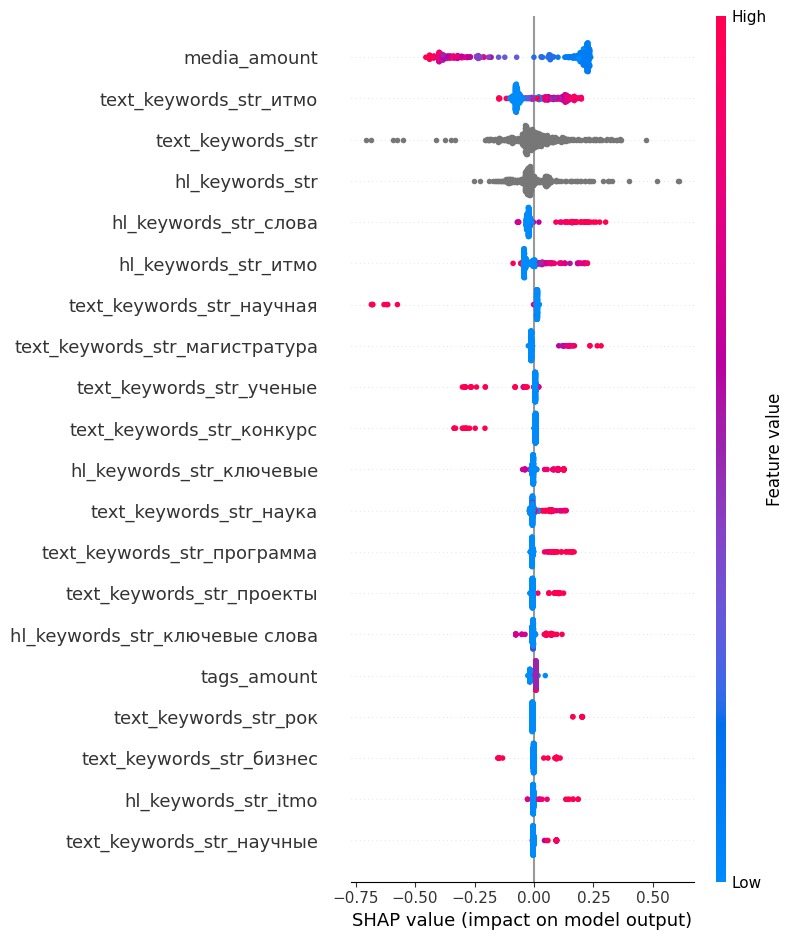

In [ ]:
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(full_pool)

shap.summary_plot(shap_values, train_tfidf_features)

Получим, что:

* большее количество вложений негативно влияют на количество просмотров;
* слова "итмо", "магистратура", "наука", "программа", "проекты", "рок", "научные" в тексте и "слова", "итмо", "itmo" влияют положительно на число просмотров;
* слова "научная", "ученые", "конкурс" в тексте влияют отрицательно на число просмотров.

Эта модель работает лучше всех предыдущих.

## Классификация с TF-IDF признаками и со всеми эмбеддингами всех моделей

Создаем большой датасет с признаками.

In [ ]:
train_tfidf_features = pd.concat([data[FEATURE_NAMES + TEXT_FEATURE_NAMES], tfidf_text_keywords_str, tfidf_hl_keywords_str, headline_features, text_features], axis=1)

Откликом будет класс, к которому отнесен пост.

In [ ]:
y_train = data['label']

Теперь сделаем бустинг.

In [ ]:
full_pool = Pool(
    data=train_tfidf_features,
    label=y_train,
    text_features=TEXT_FEATURE_NAMES,
)

predicts, models = cv(pool=full_pool, fold_count=3, stratified=True, params={'iterations': 100,
                                                                     'loss_function': 'Logloss',
                                                                     'task_type': 'GPU',
                                                                     'eval_metric': 'F1',
                                                                     'verbose': 0}, return_models=True)

Training on fold [0/3]
bestTest = 0.6850828729
bestIteration = 78
Training on fold [1/3]
bestTest = 0.6666666667
bestIteration = 32
Training on fold [2/3]
bestTest = 0.6666666667
bestIteration = 62


Посмотрим на лучший полученный результат.

In [ ]:
predicts['test-F1-mean'].max()

0.6595570590106109

Эта модель работает хуже, чем предыдущая, но лучше, чем все остальные.

## Классификация с TF-IDF признаками, эмбделлингами текстов и заголовков, соответствующими самым успешным из моделей

In [ ]:
def select_embeddings(data_gpt, embeddings, model_name):
    return embeddings[[x for x in embeddings.columns if x.startswith(model_name)]]

Создаем большой датасет с признаками.

In [ ]:
train_tfidf_features = pd.concat([data[FEATURE_NAMES + TEXT_FEATURE_NAMES], tfidf_text_keywords_str, tfidf_hl_keywords_str, headline_best_features, text_best_features], axis=1)